## Image Stitching

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Visualization func
def draw_images(image_list, title_list=None, n_cols=2, size=(7,7), suptitle=''):
    n_rows = np.ceil(len(image_list)/n_cols)
    plt.rcParams.update(plt.rcParamsDefault)
    fig = plt.figure(figsize=(n_cols*size[0], n_rows*size[1]))
    for i, image in enumerate(image_list):
        cmap = 'gray' if len(image.shape)  == 2 else None
        fig.add_subplot(n_rows, n_cols, i+1)
        plt.imshow(image,cmap=cmap)
        if title_list:
            plt.title(title_list[i])
    plt.suptitle(suptitle)
    plt.show()

### 1. Import images to stitch

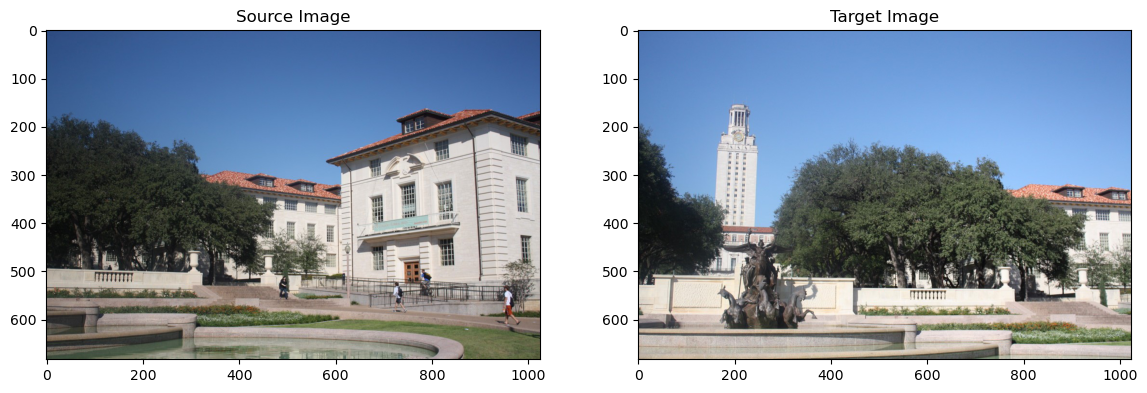

In [3]:
src_im = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
tar_im = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')

src_gray = cv2.cvtColor(src_im, cv2.COLOR_RGB2GRAY)
tar_gray = cv2.cvtColor(tar_im, cv2.COLOR_RGB2GRAY)

draw_images([src_im, tar_im], ['Source Image', 'Target Image'])

### 2. Detect SIFT keypoints, Create SIFT descriptors and Matching

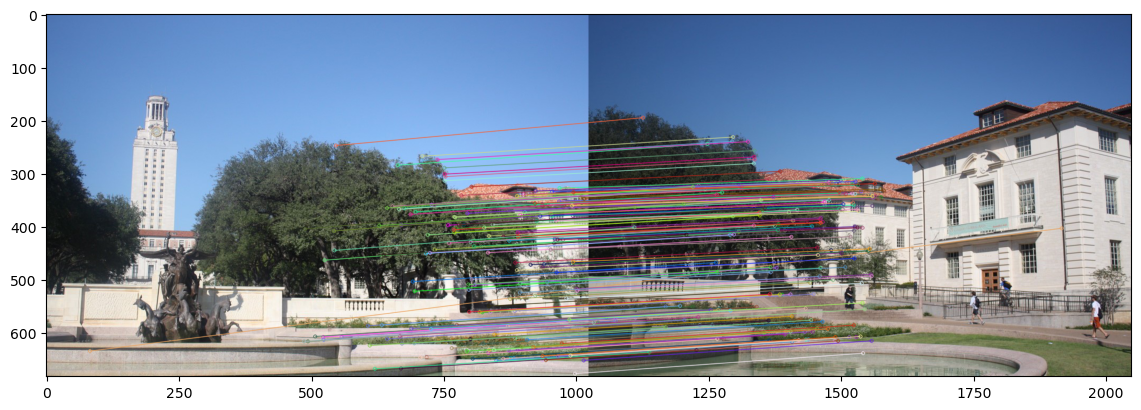

In [4]:
# Detect keypoints and create descriptors for each image
sift_obj = cv2.SIFT_create()

src_kps, src_descriptors = sift_obj.detectAndCompute(src_gray, None)
tar_kps, tar_descriptors = sift_obj.detectAndCompute(tar_gray, None)

# Find matching keypoints
# Each descriptor in the left image will match 2 best matching descriptors in the right image
# If the distance with the best matching is greater than 75% of the distance with the other, this pair will be eliminate
bf_obj = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf_obj.knnMatch(tar_descriptors, src_descriptors, k=2)
ratio = 0.75
final_matches = []
for m1, m2 in matches:
    if m1.distance < m2.distance * ratio:
        final_matches.append(m1)

final_matches = sorted(final_matches, key=lambda x: x.distance)

match_kp_im = cv2.drawMatches(tar_im, tar_kps, src_im, src_kps, final_matches[:200], None, flags=2)

plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.imshow(match_kp_im)
plt.show()

### 3. Homography Transformation

In [5]:
# Find Homography Transformation
src_pts = np.float32([kp.pt for kp in src_kps])
tar_pts = np.float32([kp.pt for kp in tar_kps])

src_match_pts = np.float32([src_pts[des.trainIdx] for des in final_matches])
tar_match_pts = np.float32([tar_pts[des.queryIdx] for des in final_matches])

(H, status) = cv2.findHomography(src_match_pts, tar_match_pts, cv2.RANSAC)

In [6]:
print(H)

[[ 7.71458162e-01  3.64050392e-02  4.46622342e+02]
 [-1.33227077e-01  9.14058155e-01  7.53097786e+01]
 [-2.05765198e-04 -3.19884165e-05  1.00000000e+00]]


### 4. Combine

In [7]:
h_tar, w_tar = tar_im.shape[:2]
h_src, w_src = src_im.shape[:2]

result_before_blending = cv2.warpPerspective(src_im, H, (w_tar + w_src, h_src))
result_before_blending[:h_tar, :w_tar, :] = tar_im

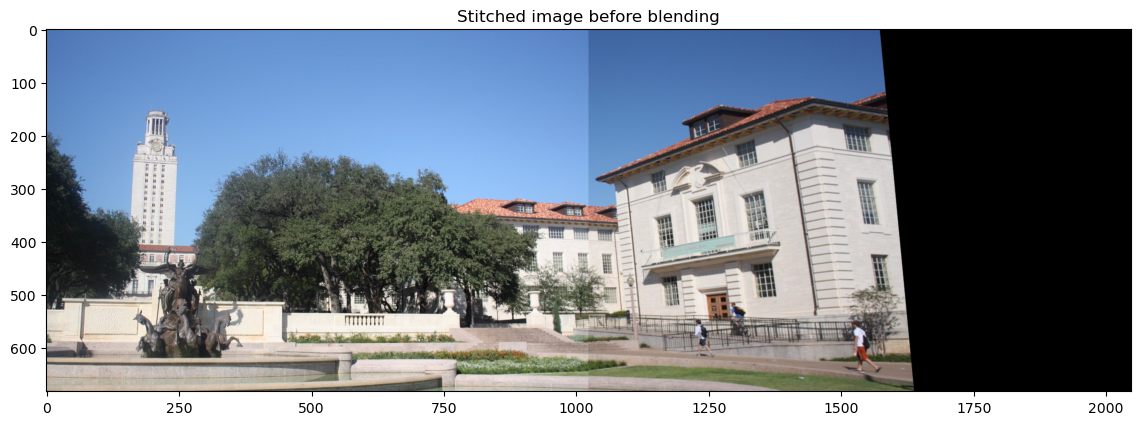

In [8]:
plt.imshow(result_before_blending)
plt.title('Stitched image before blending')
plt.show()

Blending result using Distance Transform

In [9]:
src_result = cv2.warpPerspective(src_im, H, (w_tar + w_src, h_src))
tar_result = np.zeros_like(src_result)
tar_result[:h_tar, :w_tar, :] = tar_im

In [10]:
tar_gray_result = cv2.cvtColor(tar_result, cv2.COLOR_RGB2GRAY)
_, tar_binary_result = cv2.threshold(tar_gray_result, 1, 255, cv2.THRESH_BINARY)
tar_w = cv2.distanceTransform(tar_binary_result, cv2.DIST_L2, 5)
tar_w = cv2.normalize(tar_w, None, 0, 1.0, cv2.NORM_MINMAX)

In [11]:
src_gray_result = cv2.cvtColor(src_result, cv2.COLOR_RGB2GRAY)
_, src_binary_result = cv2.threshold(src_gray_result, 1, 255, cv2.THRESH_BINARY)
src_w = cv2.distanceTransform(src_binary_result, cv2.DIST_L2, 5)
src_w = cv2.normalize(src_w, None, 0, 1.0, cv2.NORM_MINMAX)

In [12]:
result = (tar_result*tar_w[:, :, np.newaxis] + src_result*src_w[:, :, np.newaxis]) / (tar_w + src_w)[:, :, np.newaxis]
result = np.nan_to_num(result).astype(np.uint8)

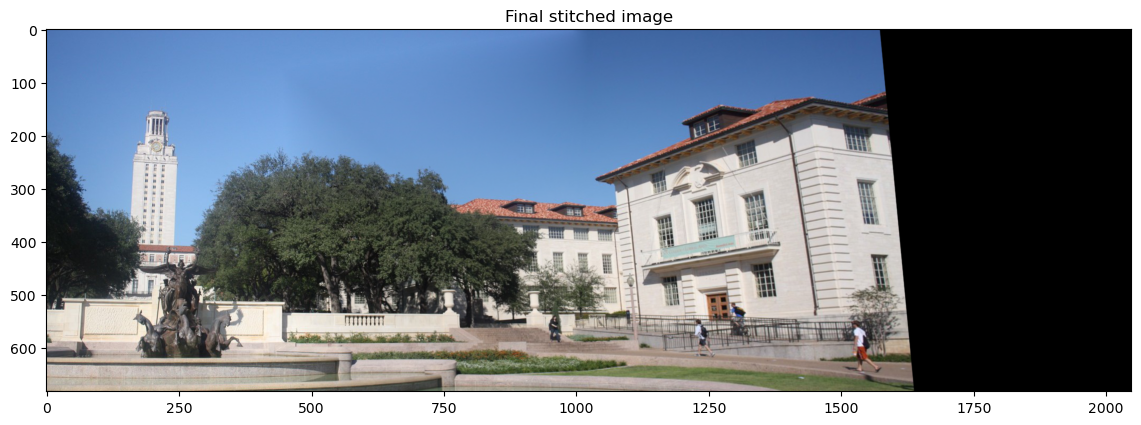

In [13]:
plt.imshow(result)
plt.title('Final stitched image')
plt.show()

### 5. Use OpenCV Stitcher

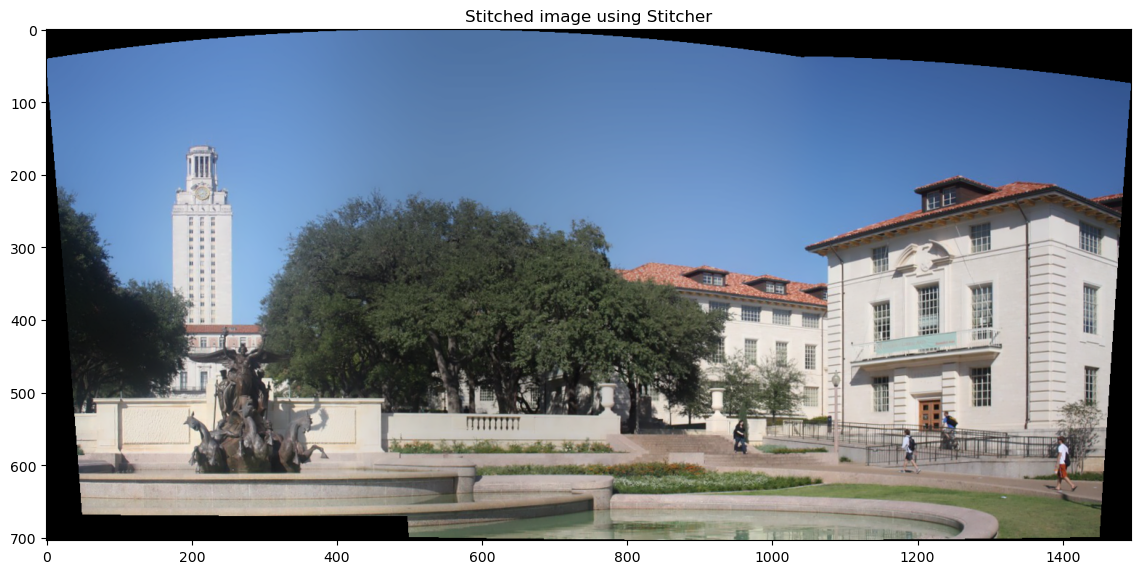

In [14]:
images = [src_im, tar_im]
stitcher = cv2.Stitcher_create()
_, cv2_result = stitcher.stitch(images)

plt.imshow(cv2_result)
plt.title('Stitched image using Stitcher')
plt.show()